In [1]:
import pygame
import zmq
import os
import threading
import numpy as np
import matplotlib.pyplot as plt

pygame 2.5.2 (SDL 2.28.2, Python 3.9.18)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:

def process_event(event):
    if event.type == pygame.KEYDOWN:
        if event.key == pygame.K_ESCAPE:
            return False
    elif event.type == pygame.QUIT:
        return False
    return True

def display_loop(screen, screen_width, screen_height, speed, stripe_width, gap_width):
    global mode
    offset = 0

    while True:
        for event in pygame.event.get():
            if not process_event(event):
                return

        if mode == DISPLAY_GRAY:
            screen.fill((128, 128, 128))
        else:
            offset += speed if mode == MOVE_RIGHT else -speed
            draw_moving_stripes(screen, screen_width, screen_height, offset, stripe_width, gap_width)

        pygame.display.flip()

def draw_moving_stripes(screen, screen_width, screen_height, offset, stripe_width, gap_width):
    screen.fill((255, 255, 255))
    stripe_color = (0, 0, 0)
    total_width = stripe_width + gap_width

    for x in range(int(offset % total_width - total_width) + int(np.floor(screen_width/8)), int(np.floor(7*screen_width/8)), total_width):
        pygame.draw.rect(screen, stripe_color, (x, 1*screen_height/8, stripe_width, 5*screen_height/8))

# def socket_server(port):
#     global mode

#     server_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
#     server_socket.bind(('', port))
#     server_socket.listen(1)

#     #print(f"Server listening on port {port}. Waiting for movement signals...")

#     while True:
#         client_socket, addr = server_socket.accept()
#         #print(f"Connection from {addr} established.")

#         data = client_socket.recv(1024).decode('utf-8')

#         if data in [MOVE_LEFT, MOVE_RIGHT, DISPLAY_GRAY]:
#             mode = data
#             #print(f"Received signal: {mode}")

#         client_socket.close()

def zmq_server(port):
    global mode

    context = zmq.Context()
    socket = context.socket(zmq.REP)
    # socket.bind("ipc://zmq_viz")
    socket.bind("tcp://*:5555")
    print("server runs")
    #print(f"Server listening on port {port}. Waiting for movement signals...")

    while True:
        data = socket.recv_string()

        if data in [MOVE_LEFT, MOVE_RIGHT, DISPLAY_GRAY]:
            mode = data
            print("Received signal: "+mode)
            socket.send_string("ack")
        if data =='INIT':      
            print("Received signal: "+data)
            socket.send_string("ack INIT")
        if data =='off':      
            print("Received signal: "+data)
            socket.send_string("ack")
        else:
            print("Received signal: "+data)
        
        

In [3]:
screen_width, screen_height = 1920, 1080
# screen_width, screen_height = 1920, 1200
pygame.init()

os.environ['SDL_VIDEO_FULLSCREEN_DISPLAY'] = '0'
screen = pygame.display.set_mode((screen_width, screen_height))

ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1342:(snd_func_refer) error evaluating name
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5727:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2721:(snd_pcm_open_noupdate) Unknown PCM default


In [4]:
speed = 0
stripe_width = 10
gap_width = 10
offset = 0
draw_moving_stripes(screen, screen_width, screen_height, offset, stripe_width, gap_width)

In [5]:
surface_str = pygame.image.tostring(screen, 'RGB')

# Convert the string buffer to a NumPy array
surface_array = np.frombuffer(surface_str, dtype=np.uint8)
surface_array = surface_array.reshape((screen_height, screen_width, 3))  # RGB means 3 channels

# # Print the NumPy array
# print(surface_array)

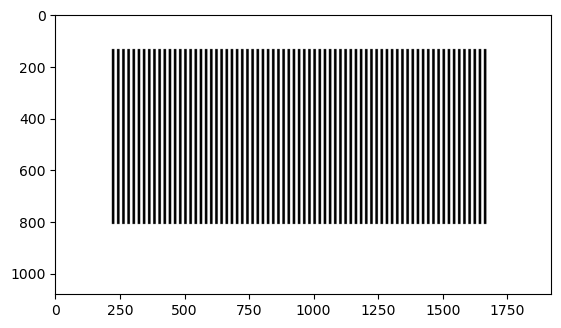

In [6]:
plt.imshow(surface_array)

In [7]:
import h5py

h = h5py.File('../data/surface_array_1920_1080.h5', 'w')
dset = h.create_dataset('data', data=surface_array)
h.close()

In [10]:
np.save('../data/image_dmd.npy', surface_array.astype(np.uint8))